# Obligatorio Machine Learning para IA

### Ramiro Sanes y Joaquin Guerra

In [255]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage import data, color
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from random import sample
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
import joblib

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

Descomprimimos la carpeta con imágenes caseras "Background" y cargamos otras imágenes de scikit learn

In [256]:
import zipfile

with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
    zip_ref.extractall('Background')

In [257]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    #filename = "Background\\" + str(i) + ".jpg"
    filename = f"Background/{i}.jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

Visualizamos las 40 imágenes (31 caseras + 9 de sklearn)

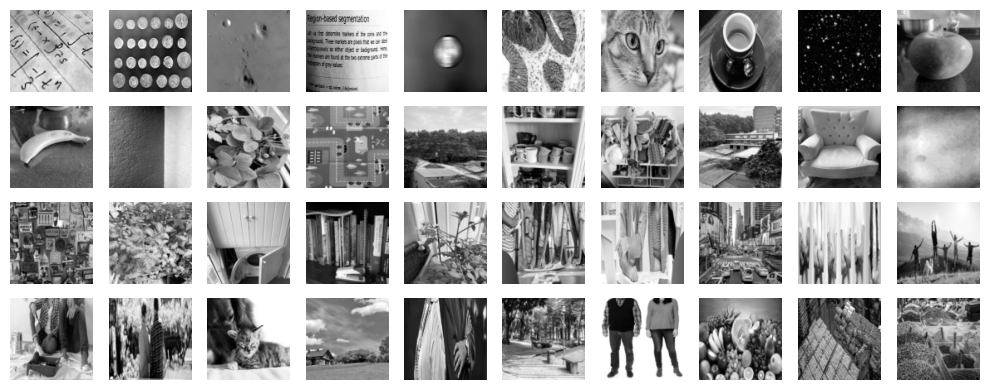

In [258]:
# Visualización
fig, ax = plt.subplots(4, 10, figsize=(10, 4), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [259]:
# Los rostros son de 64x64 por lo que vamos a usar parches de 64x64
size = (64, 64)

In [260]:
#Definimos funcion para extraer N parches de una imagen
def extract_patches(img,N,scale=1.0,patch_size = size):
    """
    Extrae N parches de una imagen
    :param image: Imagen de entrada
    :param N: Cantidad de parches a extraer
    :param scale: Escala de la imagen (1.0 = original)
    :param patch_size: Tamaño del parche
    :return: Parche extraido
    """
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [261]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


(12800, 64, 64)

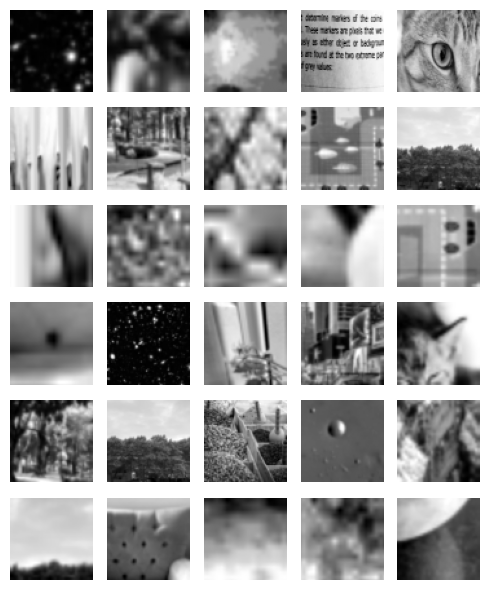

In [262]:
# Visualizamos una muestra
samples = sample(range(negative_patches.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [263]:
import zipfile

with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('Faces')

In [265]:
suffix = '.pgm'

all_files = os.listdir('Faces/Faces')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [266]:
faces = []
for filename in tqdm(pgm_files):
  path = 'Faces/Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  # agrego la imagen al array
  faces.append(image)

100%|██████████| 12833/12833 [03:18<00:00, 64.59it/s]


In [267]:
faces_array = np.stack(faces[0:1000])

In [268]:
print(type(faces_array))
print(type(negative_patches))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [269]:
X_faces = faces
y_faces = [1] * len(X_faces)  # Etiquetas para las imágenes de rostros
X_fondos = negative_patches
y_fondos = [-1] * len(X_fondos)  # Etiquetas para las imágenes de fondo

In [270]:
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])  # Etiquetas combinadas

In [271]:
print(X.shape, y.shape)

(25633, 64, 64) (25633,)


Aplanamos las imagenes

In [272]:
X = np.array([im.flatten() for im in tqdm(X, desc='Construyendo X')])

Construyendo X: 100%|██████████| 25633/25633 [00:01<00:00, 22781.72it/s]


In [273]:
X_faces_flatten = np.array([im.flatten() for im in tqdm(X_faces, desc='Construyendo X')])
X_fondos_flatten = np.array([im.flatten() for im in tqdm(X_fondos, desc='Construyendo X')])


Construyendo X: 100%|██████████| 12800/12800 [00:00<00:00, 16407.73it/s]


In [275]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [276]:
# PCA
pca_values = [2,5,10,14,15,16,20,100,200]
pca_dict = {}
for i in pca_values:
    pca_dict[i] = PCA(n_components=i, whiten=False)
    pca_dict[i].fit(X_train)

Varianza explicada con 2 componentes: 0.9011613352796295
Varianza explicada con 5 componentes: 0.9253191354804398
Varianza explicada con 10 componentes: 0.9410526512574461
Varianza explicada con 14 componentes: 0.9487431576337899
Varianza explicada con 15 componentes: 0.9500716182596234
Varianza explicada con 16 componentes: 0.9513798395280466
Varianza explicada con 20 componentes: 0.9559098349513628
Varianza explicada con 100 componentes: 0.9848937463846387
Varianza explicada con 200 componentes: 0.9924615890780214


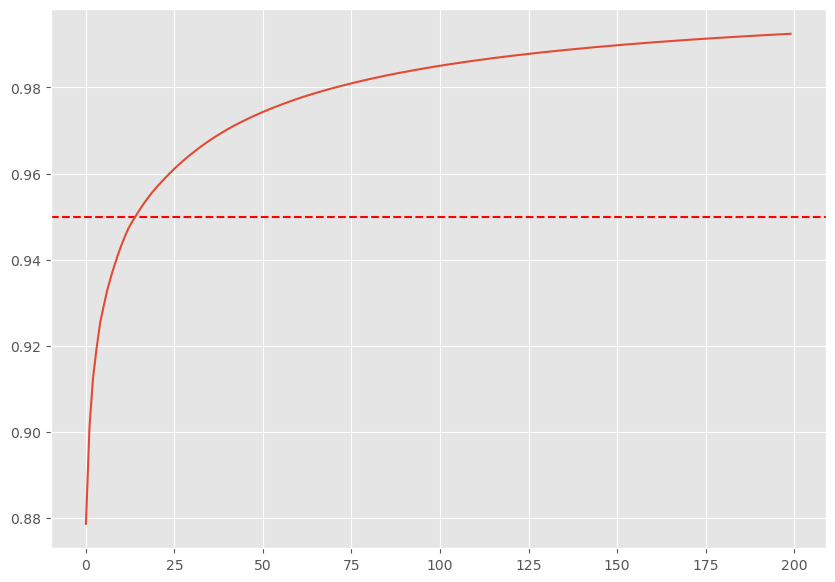

In [277]:
for i in pca_values:
    print(f"Varianza explicada con {i} componentes: {np.sum(pca_dict[i].explained_variance_ratio_)}")
    #print(f"Varianza explicada acumulada con {i} componentes: {np.cumsum(pca_dict[i].explained_variance_ratio_)}")

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_dict[200].explained_variance_ratio_), label=f'{200} componentes')
plt.show()

Tomamos 15 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada 

In [278]:
pca_final = pca_dict[15]

### Visualizamos las primeras componentes

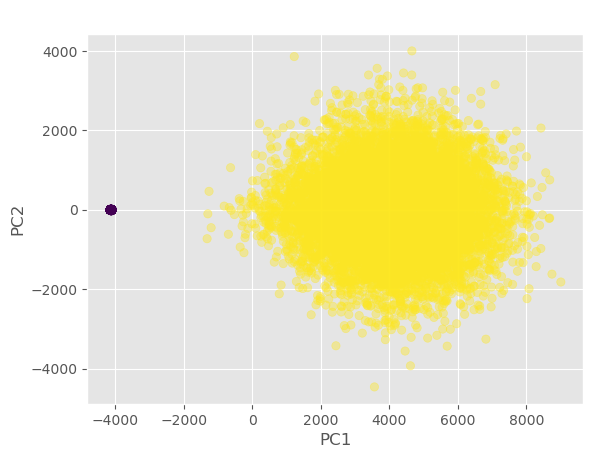

In [279]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

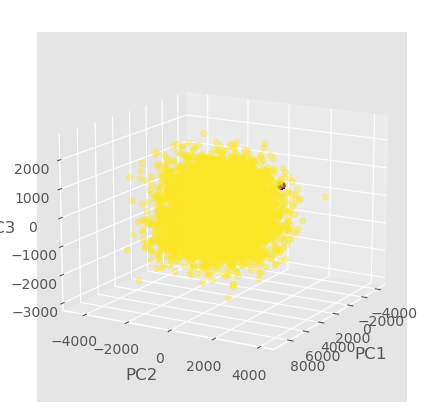

In [280]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

Podemos observar que con los 2 componentes principales, es notoria la división entre datos etiquetados como caras y datos etiquetados como fondos.
Cuando haciamos PCA solo en las caras, la cantidad de componenetes era 180, porque capturar la varianza de caras que son muy similares entre si, es mucho mas complejo que capturarla en caras y fondos juntos.

In [281]:
df = pd.DataFrame(X_pca_train, columns=[f'PC{i+1}' for i in range(X_pca_train.shape[1])])
df['y'] = y_train
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,y
0,-4119.405480,-5.753540,-20.651566,-15.087089,5.347420,18.703164,8.449627,0.791198,-4.699460,-4.635664,-7.265470,-1.189874,-1.335351,1.135575,0.511896,-1
1,-4129.155926,-4.698880,-19.569807,-24.396951,7.553130,15.873655,11.183393,3.264914,-2.487226,-1.968875,-12.267340,1.678265,2.243757,3.201338,2.825308,-1
2,-4123.719225,-6.095628,-18.371729,-17.798813,8.599554,19.783744,8.343260,1.143513,-2.532649,-4.421451,-12.689125,0.039753,-0.832614,-0.251029,2.852423,-1
3,-4129.935669,-18.548790,-15.507972,-14.472897,2.422014,22.208819,9.687958,2.968150,-4.701348,-8.178979,-12.596214,0.318230,-2.028577,1.482055,3.692378,-1
4,-4121.432547,-3.695101,-18.380000,-12.749529,-0.435445,25.074216,8.622198,0.320780,-5.884884,-5.313191,-9.781975,-3.115843,-4.603636,0.382709,0.000338,-1


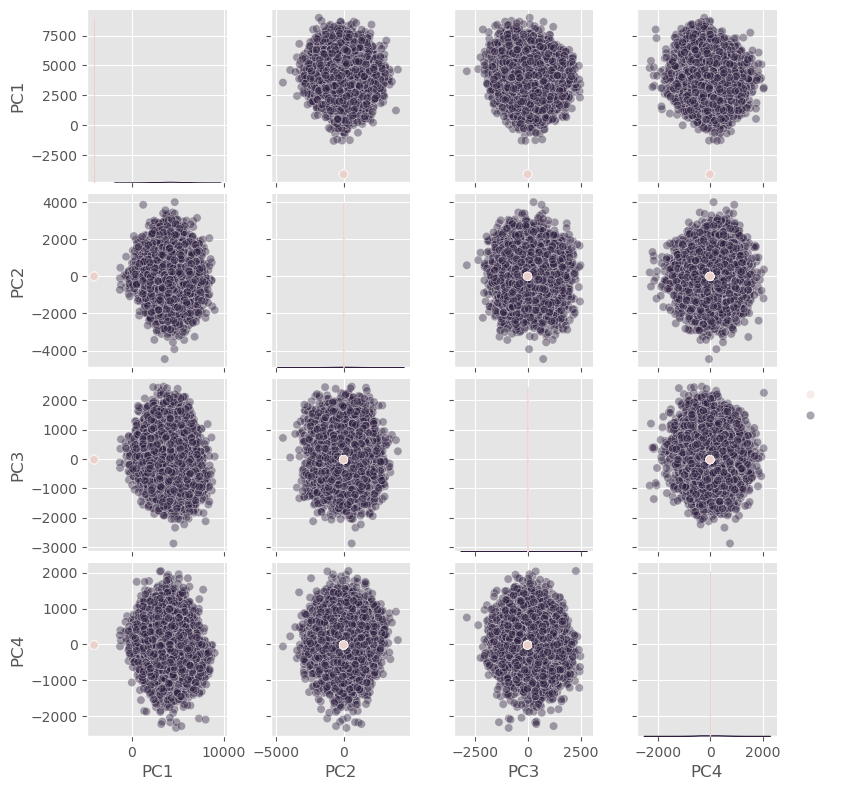

In [282]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

Observando los gráficos entendemos que 2 componentes capturan en gran medida la varianza entre los 2 subgrupos (caras y fondos), agregando las otras componentes, capturamos varianza que proviene de dentro de los subgrupos

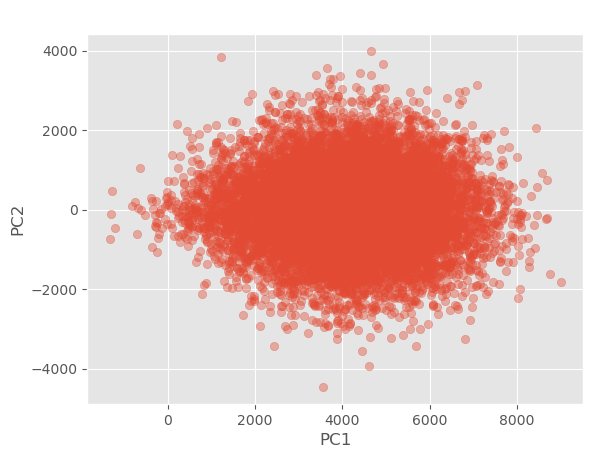

In [ ]:
X_pca_caras = pca_final.transform(X_faces_flatten)

plt.scatter(X_pca_caras[:,0], X_pca_caras[:,1], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

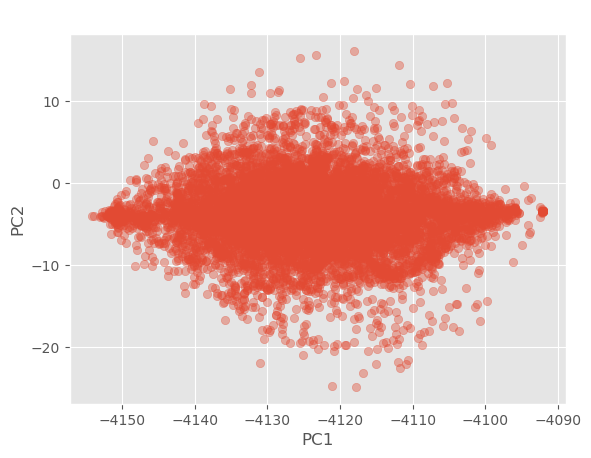

In [ ]:
X_pca_fondos = pca_final.transform(X_fondos_flatten)

plt.scatter(X_pca_fondos[:,0], X_pca_fondos[:,1], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

### Modelo sencillo de clasificación

In [283]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 1.0
Score con 5 profundidad: 1.0
Score con 10 profundidad: 1.0


In [284]:
X_pca_val = pca_final.transform(X_val)

In [285]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 1.0
Accuracy en test con profundidad 5 : 1.0
Accuracy en test con profundidad 10 : 1.0


### Probamos en Test

In [ ]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [287]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [288]:
test_images = []
for filename in tqdm(pgm_files):
  path = 'Test/Test/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  # agrego la imagen al array
  test_images.append(image)

100%|██████████| 8000/8000 [00:08<00:00, 927.60it/s] 


In [289]:
test_array = np.stack(test_images)

In [290]:
test_array.shape

(8000, 64, 64)

In [291]:
X_test_flatten = np.array([im.flatten() for im in tqdm(test_array, desc='Construyendo X')])

Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 273913.73it/s]


In [292]:
X_test_pca = pca_final.transform(X_test_flatten)

In [293]:
y_test = tree_dict[10].predict(X_test_pca)

In [294]:
test_df = pd.DataFrame(X_test_flatten)

In [295]:
test_df['prediccion'] = y_test

In [296]:
test_df.value_counts('prediccion')

prediccion
 1    7809
-1     191
Name: count, dtype: int64

In [297]:
joblib.dump(tree_dict[5], 'modelos/modelo_tree_5.pkl')

['modelos/modelo_tree_5.pkl']

In [298]:
joblib.dump(pca_final, 'modelos/pca_final_15.pkl')

['modelos/pca_final_15.pkl']

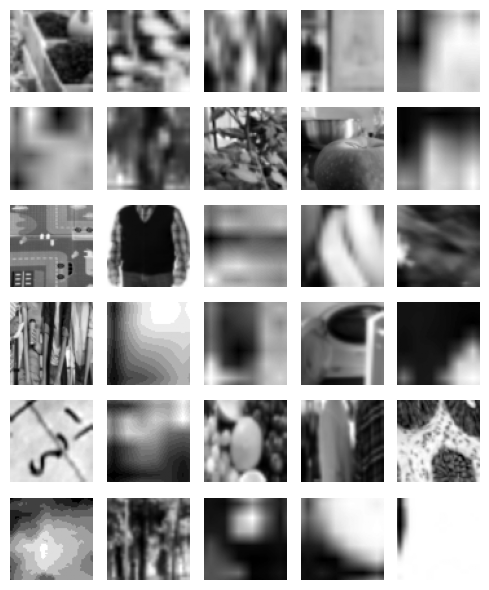

In [ ]:
# Visualizamos una muestra
samples = sample(range(test_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

Prueba Random Forest


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf_model.fit(X_pca_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
test_accuracy = rf_model.score(X_pca_val, y_val)
print("Accuracy en test:", test_accuracy)

Accuracy en test: 1.0


Probamos en test Kaggle

In [ ]:
y_pred_rf_model = rf_model.predict(X_test_pca)

In [ ]:
df_pred_rf_model = pd.DataFrame(X_test_flatten)

In [ ]:
df_pred_rf_model['prediccion'] = y_pred_rf_model

In [ ]:
df_pred_rf_model.value_counts('prediccion')

prediccion
1    7918
0      82
Name: count, dtype: int64

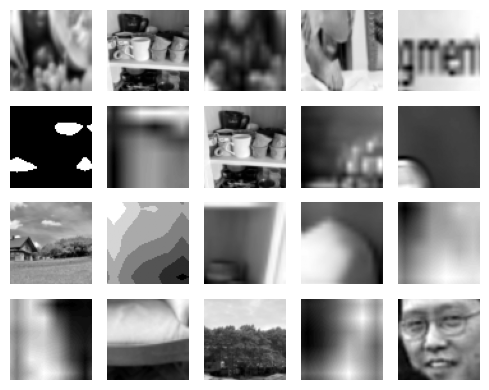

In [ ]:
#imprimir las primeras 20 imagenes de test_array
fig, ax = plt.subplots(4, 5, figsize=(5, 4), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()
for i in range(20):
    axes[i].imshow(test_array[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
test_df[0:20]['prediccion']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: prediccion, dtype: int64

In [299]:
from sklearn.ensemble import GradientBoostingClassifier

In [300]:
gb_model = GradientBoostingClassifier(random_state=42)


In [301]:
gb_model.fit(X_pca_train, y_train)

GradientBoostingClassifier(random_state=42)

In [303]:
joblib.dump(gb_model, 'modelos/xgb_1.pkl')

['modelos/xgb_1.pkl']